In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('..')

In [2]:
from simuq.solver import generate_as
from systems.ising import GenQS
#from aais.rydberg1d import GenMach
#from backends.bloqade_rydberg import transpile
from aais.rydberg2d_local import GenMach
from backends.braket_rydberg import transpile

In [3]:
N = 6
T = 1
scale_T = 3.5
scaler = scale_T / T
qs = GenQS(N, scale_T, 1 / scaler, 1 / scaler, is_chain=False)
mach = GenMach(N)

In [4]:
qs.evos[0][0].ham

[(['Z', 'Z', '', '', '', ''], 0.2857142857142857),
 (['', 'Z', 'Z', '', '', ''], 0.2857142857142857),
 (['', '', 'Z', 'Z', '', ''], 0.2857142857142857),
 (['', '', '', 'Z', 'Z', ''], 0.2857142857142857),
 (['', '', '', '', 'Z', 'Z'], 0.2857142857142857),
 (['Z', '', '', '', '', 'Z'], 0.2857142857142857),
 (['X', '', '', '', '', ''], 0.2857142857142857),
 (['', 'X', '', '', '', ''], 0.2857142857142857),
 (['', '', 'X', '', '', ''], 0.2857142857142857),
 (['', '', '', 'X', '', ''], 0.2857142857142857),
 (['', '', '', '', 'X', ''], 0.2857142857142857),
 (['', '', '', '', '', 'X'], 0.2857142857142857)]

In [5]:
Trot = 1
tol = 0.5

import time
start_time = time.time()
braket_prog = transpile(*generate_as(qs, mach, Trot, solver = 'least_squares', solver_tol = tol))
end_time = time.time()

print(end_time - start_time)
print(braket_prog)

[([((0, 0), <simuq.qmachine.Instruction object at 0x7fe51760d1c0>, <simuq.hamiltonian.TIHamiltonian object at 0x7fe517650b20>, [1.192332297053442]), ((1, 0), <simuq.qmachine.Instruction object at 0x7fe517616790>, <simuq.hamiltonian.TIHamiltonian object at 0x7fe51761eee0>, [0.5714284094676089, -1.3924655596012663e-18])], 3.5000009920111657)]
Fixing rotation by  -0.46777839526700304
i=0, ins_lvars=[1.192332297053442]
i=1, ins_lvars=[0.5714284094676089, -1.3924655596012663e-18]
2.1526341438293457


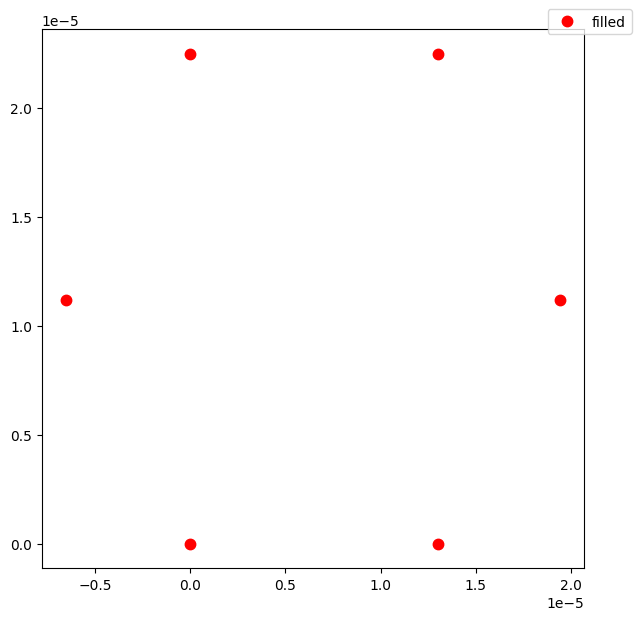

In [6]:
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
import matplotlib.pyplot as plt
import numpy as np

def show_register(register):
    filled_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.FILLED]
    empty_sites = [site.coordinate for site in register._sites if site.site_type == SiteType.VACANT]
    fig = plt.figure(figsize=(7, 7))
    if len(filled_sites) > 0:
        plt.plot(np.array(filled_sites)[:, 0], np.array(filled_sites)[:, 1], 'r.', ms=15, label='filled')
    if len(empty_sites) > 0:
        plt.plot(np.array(empty_sites)[:, 0], np.array(empty_sites)[:, 1], '.', color='k', ms=2, label='vacant')
    plt.legend(bbox_to_anchor=(1.1, 1.05))

show_register(braket_prog.register)

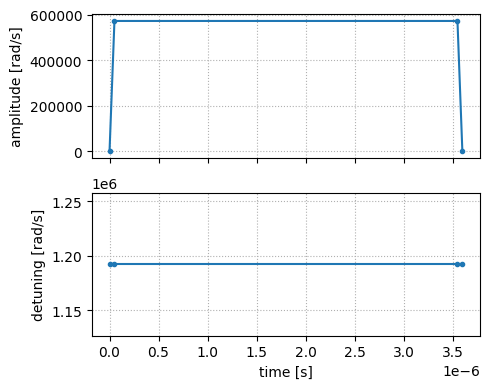

In [7]:
def show_global_drive(drive):
    data = {
        'amplitude [rad/s]': drive.amplitude.time_series,
        'detuning [rad/s]': drive.detuning.time_series,
        #'phase [rad]': drive.phase.time_series,
    }
    
    fig, axes = plt.subplots(2, 1, figsize=(5, 4), sharex=True)
    for ax, data_name in zip(axes, data.keys()):
        if data_name == 'phase [rad]':
            ax.step(data[data_name].times(), data[data_name].values(), '.-', where='post')
        else:
            ax.plot(data[data_name].times(), data[data_name].values(), '.-')
        ax.set_ylabel(data_name)
        ax.grid(ls=':')
    axes[-1].set_xlabel('time [s]')
    plt.tight_layout()

show_global_drive(braket_prog.hamiltonian)
plt.show()

In [8]:
import numpy as np
from numpy import kron, matmul
from scipy.linalg import norm, expm

def list_kron(l) :
    ret = np.array([[1]])
    for i in range(len(l)) :
        ret = kron(ret, l[i])
    return ret

def calc_prob(is_chain, N, T) :
    X = np.array([[0, 1], [1, 0]])
    Z = np.array([[1, 0], [0, -1]])
    I = np.array([[1, 0], [0, 1]])
    zero = np.array([[1], [0]])
    H_ising = np.zeros((1<<N, 1<<N))
    for i in range(N - 1 if is_chain else N) :
        l = [I for j in range(N)]
        l[i] = Z
        l[(i + 1) % N] = Z
        H_ising = H_ising + list_kron(l)
    for i in range(N) :
        l = [I for j in range(N)]
        l[i] = X
        H_ising = H_ising + list_kron(l)
    
    l = [zero for j in range(N)]
    init = list_kron(l)
    
    final = matmul(expm(-1j * T * H_ising), init)
    prob = [np.abs(final[i][0]) ** 2 for i in range(1<<N)]
    return prob

ideal_prob = calc_prob(False, N, T)
print(ideal_prob)
#ideal_prob = [0.3021633811822922, 0.0220103604525164, 0.02201036045251638, 0.026829759768424156, 0.022010360452516364, 0.0015171690483644104, 0.026829759768424118, 0.02694282896481442, 0.022010360452516472, 0.0027571786028360704, 0.0015171690483644, 0.0005236879121431605, 0.026829759768424173, 0.0005236879121431581, 0.026942828964814383, 0.022587808945176462, 0.022010360452516423, 0.0015171690483644022, 0.002757178602836066, 0.0005236879121431634, 0.0015171690483643963, 0.00023958383685457026, 0.0005236879121431612, 1.2745865712279464e-05, 0.026829759768424256, 0.0005236879121431598, 0.0005236879121431602, 0.0032596618172474104, 0.026942828964814394, 1.274586571227973e-05, 0.022587808945176428, 0.00788584927053793, 0.02201036045251644, 0.026829759768424145, 0.0015171690483644022, 0.026942828964814338, 0.0027571786028360618, 0.0005236879121431592, 0.0005236879121431628, 0.022587808945176452, 0.0015171690483644033, 0.0005236879121431621, 0.0002395838368545729, 1.2745865712279928e-05, 0.0005236879121431622, 0.003259661817247407, 1.2745865712279902e-05, 0.007885849270537915, 0.026829759768424208, 0.0269428289648144, 0.0005236879121431595, 0.02258780894517647, 0.0005236879121431607, 1.2745865712279931e-05, 0.0032596618172474104, 0.007885849270537915, 0.026942828964814383, 0.022587808945176487, 1.2745865712280006e-05, 0.00788584927053791, 0.02258780894517651, 0.007885849270537915, 0.007885849270537922, 0.026303541044756046]

[0.3021633811822922, 0.0220103604525164, 0.02201036045251638, 0.026829759768424156, 0.022010360452516364, 0.0015171690483644104, 0.026829759768424118, 0.02694282896481442, 0.022010360452516472, 0.0027571786028360704, 0.0015171690483644, 0.0005236879121431605, 0.026829759768424173, 0.0005236879121431581, 0.026942828964814383, 0.022587808945176462, 0.022010360452516423, 0.0015171690483644022, 0.002757178602836066, 0.0005236879121431634, 0.0015171690483643963, 0.00023958383685457026, 0.0005236879121431612, 1.2745865712279464e-05, 0.026829759768424256, 0.0005236879121431598, 0.0005236879121431602, 0.0032596618172474104, 0.026942828964814394, 1.274586571227973e-05, 0.022587808945176428, 0.00788584927053793, 0.02201036045251644, 0.026829759768424145, 0.0015171690483644022, 0.026942828964814338, 0.0027571786028360618, 0.0005236879121431592, 0.0005236879121431628, 0.022587808945176452, 0.0015171690483644033, 0.0005236879121431621, 0.0002395838368545729, 1.2745865712279928e-05, 0.00052368791214

In [9]:
import matplotlib.pyplot as plt
from braket.aws import AwsDevice, AwsQuantumTask
from braket.ahs.atom_arrangement import AtomArrangement, SiteType
from braket.timings.time_series import TimeSeries
from braket.ahs.driving_field import DrivingField
from braket.ahs.analog_hamiltonian_simulation import AnalogHamiltonianSimulation
from braket.devices import LocalSimulator

In [10]:
simulator = LocalSimulator("braket_ahs")
aquila_qpu = AwsDevice("arn:aws:braket:us-east-1::device/qpu/quera/Aquila")

In [26]:
aquila_qpu.properties

QueraDeviceCapabilities(service=DeviceServiceProperties(braketSchemaHeader=BraketSchemaHeader(name='braket.device_schema.device_service_properties', version='1'), executionWindows=[DeviceExecutionWindow(executionDay=<ExecutionDay.TUESDAY: 'Tuesday'>, windowStartHour=datetime.time(16, 0), windowEndHour=datetime.time(20, 0)), DeviceExecutionWindow(executionDay=<ExecutionDay.WEDNESDAY: 'Wednesday'>, windowStartHour=datetime.time(16, 0), windowEndHour=datetime.time(20, 0)), DeviceExecutionWindow(executionDay=<ExecutionDay.THURSDAY: 'Thursday'>, windowStartHour=datetime.time(16, 0), windowEndHour=datetime.time(18, 0))], shotsRange=(1, 1000), deviceCost=DeviceCost(price=0.01, unit='shot'), deviceDocumentation=DeviceDocumentation(imageUrl='https://a.b.cdn.console.awsstatic.com/59534b58c709fc239521ef866db9ea3f1aba73ad3ebcf60c23914ad8c5c5c878/a6cfc6fca26cf1c2e1c6.png', summary='Analog quantum processor based on neutral atom arrays', externalDocumentationUrl='https://www.quera.com/aquila'), devi

In [11]:
def int_to_gr(N, s) :
    ret = ''
    for i in  range(N) :
        ret += 'g' if (s>>i)&1 == 0 else 'r'
    return ret

def extract_prob(counts) :
    tot = sum(counts.values())
    freq = dict([])
    for k in counts.keys() :
        freq[k] = counts[k] / tot
    exp_prob = []
    for i in range(1<<N) :
        key = int_to_gr(N, i)
        if key not in freq.keys() :
            exp_prob.append(0)
        else :
            exp_prob.append(freq[key])
    return exp_prob

def calc_dist(prob1, prob2):
    sum_error = 0
    for i in range(len(prob1)) :
        sum_error += abs(prob1[i] - prob2[i])
    return sum_error / 2

In [12]:
sim_task = simulator.run(braket_prog, shots = 100000)

In [13]:
sim_result = sim_task.result()
sim_counts = sim_result.get_counts()

In [15]:
print(calc_dist(ideal_prob, extract_prob(sim_counts)))

0.044336068816604


In [35]:
task = aquila_qpu.run(braket_prog, shots=1000)

In [7]:
metadata = task.metadata()
task_arn = metadata['quantumTaskArn']
task_status = metadata['status']

print(f"ARN: {task_arn}")
print(f"status: {task_status}")

ARN: arn:aws:braket:us-east-1:795824654075:quantum-task/acd3ae81-a220-41a7-ac34-d3f6371cb516
status: COMPLETED


In [16]:
# Reload a task
from braket.aws import AwsQuantumTask
task = AwsQuantumTask(arn="arn:aws:braket:us-east-1:795824654075:quantum-task/acd3ae81-a220-41a7-ac34-d3f6371cb516")   # Fill in the task arn

In [17]:
result = task.result()

In [18]:
counts = dict([])
for i in range(result.task_metadata.shots) :
    if sum(result.measurements[i].pre_sequence) == N :
        s = ''
        for j in range(N) :
            s += 'g' if result.measurements[i].post_sequence[j] == 1 else 'r'
        if s not in counts.keys() :
            counts[s] = 1
        else :
            counts[s] +=1 
print(counts)

{'gggggg': 438, 'rggggg': 66, 'grgggg': 48, 'gggrgg': 67, 'ggrrgg': 5, 'gggggr': 87, 'gggrgr': 19, 'grgrgg': 11, 'ggggrg': 76, 'rgggrg': 5, 'ggrgrg': 9, 'rggrrg': 5, 'ggrggg': 57, 'rrgggg': 4, 'rgrggg': 5, 'grgggr': 9, 'rggggr': 8, 'grgrgr': 2, 'rggrgg': 14, 'ggggrr': 10, 'gggrrg': 7, 'grrggg': 7, 'grrrgg': 2, 'grggrg': 7, 'rgggrr': 2, 'ggrggr': 6, 'grrgrg': 1, 'ggrrgr': 1, 'ggrgrr': 1, 'grrggr': 1, 'rggrgr': 1, 'grggrr': 1, 'rrggrg': 1, 'ggrrrg': 2, 'rrgggr': 1, 'rrrggr': 1, 'grgrrg': 1, 'rrgrrg': 1}


In [19]:
print(calc_dist(ideal_prob, extract_prob(counts)))

0.49289101366758087
